<h2>Read and play the signals</h2>

<h3 color='g'>Question<h3>
--- why the sampling frequency not the same when I read a signal using scipy and librosa???

In [1]:
import numpy as np
import matplotlib.pylab as plt
import scipy
import librosa
import librosa.display
from IPython.core.display import display
import IPython.display as ipd
from data import create_spec
import os
import torch
from torch import nn
from args import config
args= config()

from torch import nn
from train_unet import train
from model import My_unet
from torchvision import transforms
from data import MyDataset
from train_unet import get_pesq, get_stoi
from torch.utils.data import DataLoader, random_split

C:\Users\imane\AppData\Local\Temp\ipykernel_10984\2281652912.py:6: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


In [ ]:
sig_noisy_path= "data/train_small/noisy/signal/Jules_Verne_-_L_ile_mysterieuse_Partie1_Chap01_0_.wav"
sig_path= "data/train_small/original/signal/Jules_Verne_-_L_ile_mysterieuse_Partie1_Chap01_0_.wav"

fs_noisy, sig_noisy = scipy.io.wavfile.read(sig_noisy_path)
fs, sig = scipy.io.wavfile.read(sig_path)

print("noisy singnal:")
display(ipd.Audio(data= sig_noisy, rate= fs))
print("original signal:")
display(ipd.Audio(data= sig, rate=fs))

In [ ]:
sign= librosa.load(sig_path)

signal, fs= sign

In [ ]:
print('teh shape of the original signal is: {}'.format(sig.shape))
print(" the sampling frequency is: {}".format(fs))


In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
plt.plot(sig, label='orginal signal')
plt.title('Original signal')

plt.subplot(2,1,2)
plt.plot(sig_noisy)
plt.title("noisy singal")
plt.show()

<h2>Get the spectrograms and visualze:

In [ ]:
#get stft
stft_noisy= librosa.stft(sig_noisy.astype(float))
stft_origin= librosa.stft(sig.astype(float))
# get the mel
# mel_noisy= librosa.feature.melspectrogram(y=sig_noisy.astype(float), sr= fs_noisy)
# mel_origin= librosa.feature.melspectrogram(y=sig.astype(float), sr= fs)


# Displaying the results
fig, ax = plt.subplots(1, 2, figsize=(15, 10))

librosa.display.specshow(librosa.amplitude_to_db(abs(stft_noisy)),
                         sr=fs_noisy, x_axis='time', y_axis='log', ax=ax[0], cmap='viridis')
ax[0].set_title('STFT of Noisy Signal')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Frequency')

librosa.display.specshow(librosa.amplitude_to_db(abs(stft_origin)),
                         sr=fs, x_axis='time', y_axis='log', ax=ax[1], cmap='viridis')
ax[1].set_title('STFT of Original Signal')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Frequency')

# librosa.display.specshow(librosa.power_to_db(mel_noisy),
#                          sr=fs_noisy, x_axis='time', y_axis='mel', ax=ax[1, 0], cmap='viridis')
# ax[1, 0].set_title('Mel Spectrogram of Noisy Signal')
# ax[1, 0].set_xlabel('Time')
# ax[1, 0].set_ylabel('Mel')

# librosa.display.specshow(librosa.power_to_db(mel_origin),
#                          sr=fs_noisy, x_axis='time', y_axis='mel', ax=ax[1, 1], cmap='viridis')
# ax[1, 1].set_title('Mel Spectrogram of Origin Signal')
# ax[1, 1].set_xlabel('Time')
# ax[1, 1].set_ylabel('Mel')

We can clearly differentiate between some features of the original signal and noisy signal

In [ ]:
# ## store the spectrogram images
signals_path='data/test'
n_fft= args.n_fft
hop_length_fft= args.hop_length_fft
create_spec(signals_path, n_fft,hop_length_fft, noisy=True)


In [ ]:

files= os.listdir('data/test/noisy/signal/')
print('nb files:', len(files))
spec= os.listdir('data/test/noisy/phase/')
print('nb spec:', len(spec))


In [ ]:
#after creating spec and phase retreive the audio signal
from data import retreive_sig
from PIL import Image
path_spec='data/train_small/original/spec/Jules_Verne_-_L_ile_mysterieuse_Partie1_Chap01_0_.wav.npy'
path_phase= 'data/train_small/original/phase/Jules_Verne_-_L_ile_mysterieuse_Partie1_Chap01_0_.wav.npy'
spec= np.load(path_spec)
plt.imshow(spec)
plt.title("spec of signal to be retreived")
phase= np.load(path_phase)
# plt.imshow(spec)
print(spec.shape)
fs= 8000
audio_retrieved= retreive_sig(spec, phase, args.n_fft, args.hop_length_fft)
plt.figure(figsize=(10,4))
plt.plot(audio_retrieved)
plt.title('retreived signal')
plt.show()

display(ipd.Audio(data= audio_retrieved, rate= fs))
print(audio_retrieved.shape)

<h2>Train baseline model</h2>

In [ ]:
import torch
from model import My_unet
x= torch.rand(1,1,256,256)

print(x.shape)

model= My_unet(1,5)

out= model(x)
# cov1 , down1= out
print(out.shape)
# print(cov1.shape)
# print(down1.shape)

In [ ]:
path_phase.split('.')[0]

In [2]:
# create dataset class and get data
from torchvision import transforms
from data import MyDataset
from train_unet import get_pesq, get_stoi
from torch.utils.data import DataLoader, random_split


path= 'data/train_small/'

transform= transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

dataset= MyDataset(path, transform=transform)
train_set, val_set= random_split(dataset, [0.81, 0.19])
# data loader
train_loader= DataLoader(dataset, batch_size= 1, shuffle= True)
val_loader= DataLoader(dataset, batch_size= 1, shuffle= True)


# write train loop 
for i, data in enumerate(train_loader):
    noisy_spec_val, original_spec_val,  noisy_phase_val, original_singal_val = data
    # print(type(ori))
    print(noisy_spec_val.shape)
    print(original_singal_val[1].shape)
    resize_spec= transforms.Resize((args.height, args.width))
    r= resize_spec(noisy_spec_val)
    # print(r)
    a= get_stoi(original_singal_val, noisy_spec_val, noisy_phase_val)
    print(a)
    # suppoose I want to see the effect of the noise
    break
#visualize the output of the unet 

ValueError: too many values to unpack (expected 4)

In [ ]:
#bluid train loop 


model= My_unet(in_channels=1, out_channels=1)

nepochs= 5
batch_size= 1
train_losses, val_losses, val_pesq_scores, val_stoi_scores= train(model, data_path='data/train_small/', batch_size= batch_size, n_epochs= nepochs, transform=transform, save_path=None)

# Plot training and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
plt.plot(val_pesq_scores, label='PESQ')
plt.plot(val_stoi_scores, label='STOI')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('PESQ and STOI')
plt.legend()
plt.show()

In [ ]:
# test the model:
from torch import nn
from test_unet import test
from model import My_unet

model= My_unet(in_channels=1, out_channels=1)

nepochs= 5
batch_size= 1
average_test_loss, average_pesq_score, average_stoi_score= test(model, data_path='data/train_small/', checkpoint_path='', batch_size= batch_size, transform=transform, save_path=None)

In [ ]:
import os

# Define the directory containing the files
directory = 'data/train_small/original/phase'

# Iterate over all files in the directory
for filename in os.listdir(directory):
    if filename.endswith(".wav.npy"):
        # Construct the old file path
        old_file = os.path.join(directory, filename)

        # Construct the new file name by removing '.wav'
        new_filename = filename.replace('.wav', '')

        # Construct the new file path
        new_file = os.path.join(directory, new_filename)

        # Rename the file
        os.rename(old_file, new_file)
        print(f"Renamed '{old_file}' to '{new_file}'")


##############################################################################################################################################################################################################

In [2]:
# try out differetn size filters:
from model_2 import My_unet_2

model=My_unet_2(10,4)
data_path='data/train_small/'
# dataset= MyDataset(data_path, transform=None)
dataset= torch.randn((100, 10, 128, 128))
train_loader= DataLoader(dataset, batch_size= 10, shuffle= True)


for data in train_loader:
    noisy_spec= data
    print(noisy_spec.shape)
    predicted = model(noisy_spec)
    print(predicted.shape)
    break
        

torch.Size([10, 10, 128, 128])
torch.Size([10, 4, 128, 128])


Loading the data...
Device: cpu

 start training


  0%|          | 0/2 [00:00<?, ?it/s]c:\Users\imane\MVA\Apprentissage profond et traitement du signal, introduction et applications industrielles\Projet\.venv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
 50%|█████     | 1/2 [00:21<00:21, 21.96s/it]

Epoch 1, Train Loss: 4217.5835, Validation Loss: 47838.7188, Average PESQ: 1.1584, Average STOI: 0.3021


100%|██████████| 2/2 [00:45<00:00, 22.65s/it]

Epoch 2, Train Loss: 52133.7891, Validation Loss: 3372.3953, Average PESQ: 1.1718, Average STOI: 0.4576


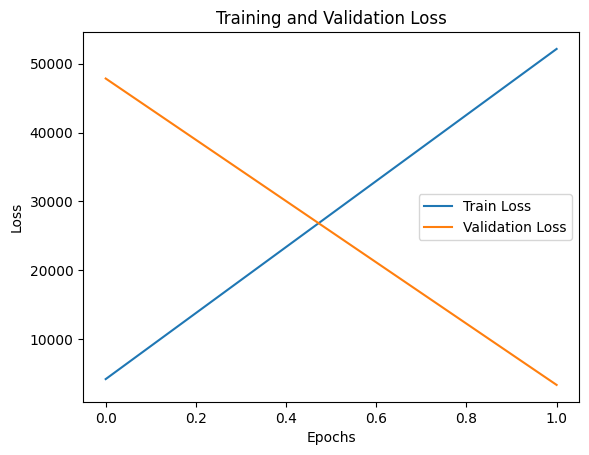

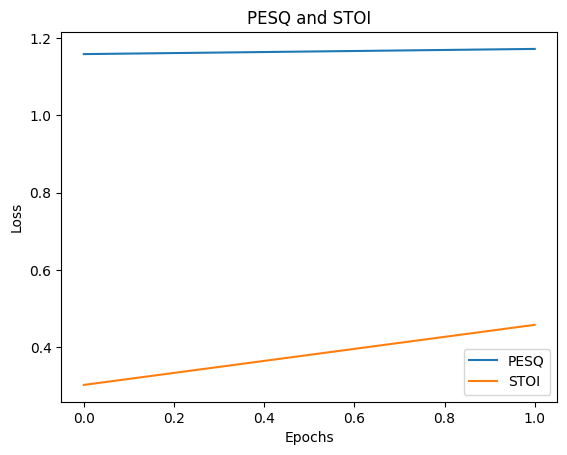

In [4]:
#bluid train loop
from torch import nn
from train_unet import train
from model_2 import My_unet_2
model= My_unet_2(in_channels=1, out_channels=1)

loss= nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.1)
scheduler= torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)

nepochs= 50
batch_size= 1
save_dir= '/content/checkpoints_2'
# os.makedirs(save_dir, exist_ok= True)
train_losses, val_losses, val_pesq_scores, val_stoi_scores= train(model, data_path='data/train_small/', batch_size= 32, n_epochs= 2, transform=transform, save_dir=save_dir)

# Plot training and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
plt.plot(val_pesq_scores, label='PESQ')
plt.plot(val_stoi_scores, label='STOI')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('PESQ and STOI')
plt.legend()
plt.show()